In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
%matplotlib inline

In [2]:
# Trade data for MSFT
df = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
apple = df[df['RIC'] == 'MSFT.O']
apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date

<ipython-input-2-eaae533fcb53>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date


In [3]:
# Auction price data
auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
apple_auction = auction[auction['RIC'] == 'MSFT.O']
apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date

<ipython-input-3-938478aed39c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date


In [55]:
# Data Processing (10 minute intervals)

dates = apple['Date'].unique()
daily_volatility = []
avg_20day_volatility = []
stocks = []
dates_final = []
auction_volatility = []
volumes = []

i = 0
for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min_volume = pd.DataFrame(apple_today['Volume'].resample("10T").sum())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    apple_today_10min = apple_today_10min.join(apple_today_10min_volume)
    apple_today_10min['Volatility'] = (apple_today_10min['High']-apple_today_10min['Low']) # alternate volatility formula
#     apple_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1) * np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
    volatility_today = apple_today_10min['Volatility'].values
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
#     auction_volatility_today = apple_auction_today['Price'].iloc[0]-apple_today_10min['Open'][-1]
    auction_volatility_today = (apple_auction_today['Price'].iloc[0]-apple_today_10min['Open'][-1]) / apple_today_10min['Open'][-1]  
    auction_volatility.append(auction_volatility_today)
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
    
    # Average daily volatility (later used for 20 day moving average)
    daily_volatility.append(np.mean(volatility_today))
    
    # Total volume for each complete trade day between 930 and 1550
    volumes.append(sum(apple_today_10min[:-1]['Volume']))
    
    if i < 20: # Cannot calculate 20 day moving average if there are fewer than 20 preceding days
        avg_20day_volatility.append(None)
    else:
        j = i-20
        avg_20day_volatility.append(np.mean(daily_volatility[j:i]))
    i += 1

stocks = stocks[20:]
stocks = np.vstack(stocks).T # Training data for Anderson model
avg_20day_volatility_raw = avg_20day_volatility
avg_20day_volatility = avg_20day_volatility[20:] # Sigma_t input for Anderson model

In [56]:
# Rows with 3:50pm information
apple_price_1550 = apple[apple['Local_Date_Time'].str.contains("15:50")]

In [57]:
# Merge the above two tables
method1 = apple_price_1550.merge(apple_auction, on='Date')

In [58]:
#################################################
#####          BASE MODEL OUTPUT            #####
#################################################

# Simply take the price at 350pm of the trading day (MAE/MSE)
print('Average MAE for the 350pm method is:', sum(abs(method1['Price'] - method1['Open']))/251) # 0.2863
print('Average MSE for the 350pm method is:', sum(abs(method1['Price'] - method1['Open'])**2/251)) # 0.1842

# Close at 350pm - auction
diff1 = method1['Price']-method1['Open']
print(len(diff1[diff1>0])) # 116 times where the order was higher than open at 350pm

Average MAE for the 350pm method is: 0.530004780876494
Average MSE for the 350pm method is: 0.45253891322709117
116


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         2.,  2.,  4.,  2.,  3.,  3.,  7.,  6., 13.,  8.,  8., 14., 12.,
        16., 11.,  9., 14., 14., 14., 13., 13., 17.,  5.,  7.,  5.,  8.,
         2.,  3.,  6.,  1.,  1.,  2.,  1.,  0.,  0.,  1.,  1.]),
 array([-2.7   , -2.6088, -2.5176, -2.4264, -2.3352, -2.244 , -2.1528,
        -2.0616, -1.9704, -1.8792, -1.788 , -1.6968, -1.6056, -1.5144,
        -1.4232, -1.332 , -1.2408, -1.1496, -1.0584, -0.9672, -0.876 ,
        -0.7848, -0.6936, -0.6024, -0.5112, -0.42  , -0.3288, -0.2376,
        -0.1464, -0.0552,  0.036 ,  0.1272,  0.2184,  0.3096,  0.4008,
         0.492 ,  0.5832,  0.6744,  0.7656,  0.8568,  0.948 ,  1.0392,
         1.1304,  1.2216,  1.3128,  1.404 ,  1.4952,  1.5864,  1.6776,
         1.7688,  1.86  ]),
 <BarContainer object of 50 artists>)

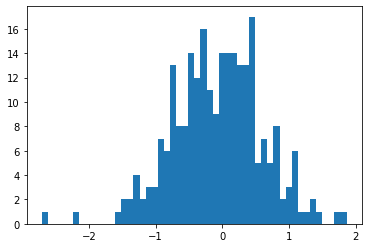

In [59]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.hist(diff1, bins=50)

In [60]:
#####################################################
#####  BASE MODEL OUTPUT (only last 31 values)  #####
#####################################################

# Later in Andersen model, we only test with the last 31 values of AAPL stocks

# Simply take the price at 350pm of the trading day (MAE/MSE)
print('Average MAE for the 350pm method is:', sum(abs(method1[-31:]['Price'] - method1[-31:]['Open']))/31) # 0.3845
print('Average MSE for the 350pm method is:', sum(abs(method1[-31:]['Price'] - method1[-31:]['Open'])**2/31)) # 0.2530

# Close at 350pm - auction
diff1 = method1[-31:]['Price']-method1[-31:]['Open']
print(len(diff1[diff1>0])) # 14/31 times where the order was higher than open at 350pm

Average MAE for the 350pm method is: 0.3845161290322604
Average MSE for the 350pm method is: 0.2530000000000011
14


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        2., 0., 0., 2., 1., 0., 2., 0., 0., 1., 1., 2., 3., 0., 2., 1., 2.,
        0., 1., 1., 0., 3., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([-1.47  , -1.4198, -1.3696, -1.3194, -1.2692, -1.219 , -1.1688,
        -1.1186, -1.0684, -1.0182, -0.968 , -0.9178, -0.8676, -0.8174,
        -0.7672, -0.717 , -0.6668, -0.6166, -0.5664, -0.5162, -0.466 ,
        -0.4158, -0.3656, -0.3154, -0.2652, -0.215 , -0.1648, -0.1146,
        -0.0644, -0.0142,  0.036 ,  0.0862,  0.1364,  0.1866,  0.2368,
         0.287 ,  0.3372,  0.3874,  0.4376,  0.4878,  0.538 ,  0.5882,
         0.6384,  0.6886,  0.7388,  0.789 ,  0.8392,  0.8894,  0.9396,
         0.9898,  1.04  ]),
 <BarContainer object of 50 artists>)

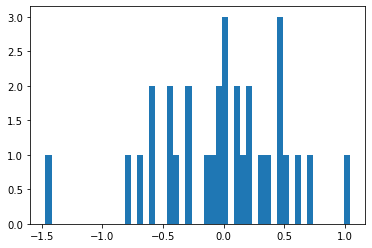

In [61]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.hist(diff1, bins=50)

In [62]:
# Andersen Model
class FlexibleFourierRegression():
    '''
    See P.152 Anderson(1997) Appendix B for details
    '''
    
    def __init__(self, N, J=0, P=0, di=[]):
        self.J = J
        self.D = len(di)
        self.P = P
        
        self.N = N
        self.di = di
        self.Id = zeros(shape=(N,))
        self.mu0 = ones(shape=(J+1,))
        self.mu1 = ones(shape=(J+1,))
        self.mu2 = ones(shape=(J+1,))
        self.lamb = ones(shape=(self.D,))
        self.gamma = ones(shape=(P, J+1))
        self.delta = ones(shape=(P, J+1))
        self.p = arange(1, P + 1, 1)
        self.x = concatenate([self.mu0.ravel(), self.mu1.ravel(), self.mu2.ravel(),
            self.lamb.ravel(), self.gamma.ravel(), self.delta.ravel()])    
        
    def train(self, y, sigma_t, tol=0.1):
        """
        Trains model using flexible fourier functional form.
        
        Parameters
        ----------
        y : dependent variable
        
        sigma_t: estimated conditional volatility for day t,
        sigma_t is scalar or vector depending on vector=False/True.
        
        
        
        Returns
        -------
        Regression stats
        """
        assert y.shape[0] == self.N, "input y should have shape[0] == N:"
        n = arange(0, self.N, 1)
        J = self.J
        ## Learning weights for the following parameters
        ## self.mu0, self.mu1, self.mu2, self.lamb, self.gamma, self.delta

        def lsq_fun(x):
            
            mu0 = x[0: J+1]
            mu1 = x[J+1: 2*J+2]
            mu2 = x[2*J+2: 3*J+3]
            lamb = x[3*J+3:3*J+3+self.D]
            gamma = x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
            delta = x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
            
            gamma = repeat(expand_dims(gamma, axis=0), self.N, axis=0)
            delta = repeat(expand_dims(delta, axis=0), self.N, axis=0)            
            N1 = (self.N + 1) / 2
            N2 = (self.N + 1) * (self.N + 2) / 6            
            
            dummy = self.Id.copy()
            dummy[self.di] = lamb
            dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
            
            mu0 = repeat(expand_dims(mu0, axis=0), self.N, axis=0)
            quad = mu0 + outer(n / N1, mu1) + outer(square(n) / N2, mu2)
            cosine = cos(2 * outer(n, self.p) * pi / self.N)
            sine = sin(2 * outer(n, self.p) * pi / self.N)
            cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
            sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)  
            fourier_expand = gamma * cosine + delta * sine
            fourier = fourier_expand.sum(axis=1)

            sigma = full(fill_value=sigma_t, shape=(self.N, J+1))
            for j in range(J+1):
                sigma[:,j] = power(sigma[:,j], j)   

            result = (sigma * (quad + dummy + fourier)).sum(axis=-1)
            cost = square(result - y).mean()
            
            return cost

        def lsq_fun_vec(x):
            
            mu0 = x[0: J+1]
            mu1 = x[J+1: 2*J+2]
            mu2 = x[2*J+2: 3*J+3]
            lamb = x[3*J+3:3*J+3+self.D]
            gamma = x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
            delta = x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
            
            gamma = repeat(expand_dims(gamma, axis=0), self.N, axis=0)
            delta = repeat(expand_dims(delta, axis=0), self.N, axis=0)            
            N1 = (self.N + 1) / 2
            N2 = (self.N + 1) * (self.N + 2) / 6            
            
            dummy = self.Id.copy()
            dummy[self.di] = lamb
            dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
            
            mu0 = repeat(expand_dims(mu0, axis=0), self.N, axis=0)
            quad = mu0 + outer(n / N1, mu1) + outer(square(n) / N2, mu2)
            cosine = cos(2 * outer(n, self.p) * pi / self.N)
            sine = sin(2 * outer(n, self.p) * pi / self.N)
            cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
            sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)  
            fourier_expand = gamma * cosine + delta * sine
            fourier = fourier_expand.sum(axis=1)
            
            component = fourier + quad + dummy
            component = repeat(expand_dims(component, axis=1), len(sigma_t), axis=1)  
            
            sigma = repeat(expand_dims(sigma_t, axis=0), self.N, axis=0)
            sigma_J = repeat(expand_dims(sigma, axis=-1), J+1, axis=-1)
            for j in range(J+1):
                sigma_J[:,:,j] = power(sigma_J[:,:,j], j)   
            
            result = (sigma_J * component).sum(axis=-1)
            cost = square(result - y).mean()
            
            return cost
        

        sigma_t = ravel(sigma_t)
        assert sigma_t.shape[0] == y.shape[1], "sigma_t should have shape (t, ) and y should have shape (N, t)"
        res = minimize(lsq_fun_vec, self.x, tol=tol)

        self.mu0 = res.x[0: J+1]
        self.mu1 = res.x[J+1: 2*J+2]
        self.mu2 = res.x[2*J+2: 3*J+3]
        self.lamb = res.x[3*J+3:3*J+3+self.D]
        self.gamma = res.x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
        self.delta = res.x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))            
        
        return res
        
    def predict(self, sigma_t, vector=False):
        
        N = self.N
        D = self.D
        J = self.J
        P = self.P
        p = self.p
        
        gamma = repeat(expand_dims(self.gamma, axis=0), N, axis=0)
        delta = repeat(expand_dims(self.delta, axis=0), N, axis=0)
        n = arange(0, N, 1)
        N1 = (N + 1) / 2
        N2 = (N + 1) * (N + 2) / 6
        
        dummy = self.Id.copy()
        dummy[self.di] = self.lamb
        dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
        
        quad = self.mu0 + outer(n / N1, self.mu1) + outer(square(n) / N2, self.mu2)
        
        cosine = cos(2 * outer(n, self.p) * pi / N)
        sine = sin(2 * outer(n, self.p) * pi / N)
        cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
        sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)
        fourier_expand = gamma * cosine + delta * sine
        fourier = fourier_expand.sum(axis=1)

        sigma_t = ravel(sigma_t)
        component = fourier + quad + dummy
        component = repeat(expand_dims(component, axis=1), sigma_t.shape[0], axis=1)  
        sigma = repeat(expand_dims(sigma_t, axis=0), self.N, axis=0)
        sigma_J = repeat(expand_dims(sigma, axis=-1), J+1, axis=-1)
        for j in range(J+1):
            sigma_J[:,:,j] = power(sigma_J[:,:,j], j)               
        result = (sigma_J * component).sum(axis=-1)
            
        return result

In [63]:
# Arbitrary train/test split - 200 days of training and 31 days of testing
stocks2 = stocks.T
stocks2 = stocks2[:200].T
avg_20day_volatility2 = avg_20day_volatility[:200]

In [64]:
fourier = FlexibleFourierRegression(N=39, di=[], J=10, P=20) # 39 10-minute intervals in each trade day
res = fourier.train(stocks, avg_20day_volatility, 0.005)
print("optimizer success: {}".format(res.success))
print("objective function (mse): {:.5f}".format(res.fun))

optimizer success: True
objective function (mse): 0.10967


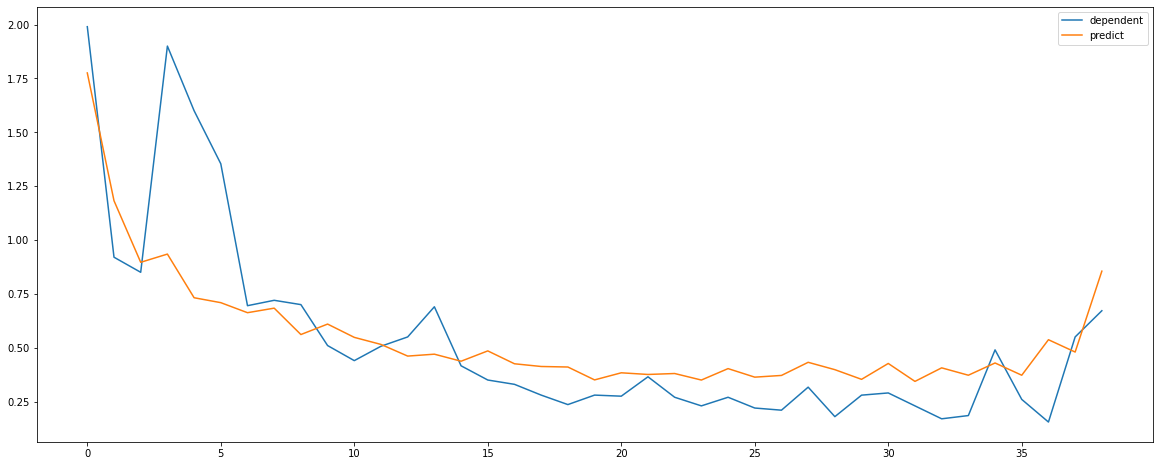

In [65]:
n=227
result = fourier.predict(avg_20day_volatility[n])

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(stocks.T[n], label="dependent")
ax.plot(result, label="predict")
ax.legend()

In [66]:
results = [None for i in range(20)]
for vol in avg_20day_volatility:
    result = fourier.predict(vol)
    results.append(result[-1][0])
results = np.array(results)

In [67]:
# Simple linear regression with Anderson coefficient
final_df = pd.DataFrame({
    'Date': dates_final,
    'Volume': volumes,
    'Avg20_Volatility': avg_20day_volatility_raw,
    'Anderson': results,
    'Auction_Volatility': auction_volatility
})
final_df = final_df[final_df['Avg20_Volatility'] <= float('inf')]
final_df

,Date,Volume,Avg20_Volatility,Anderson,Auction_Volatility
20,2020-09-30,19083581,1.008009,0.912387,-0.001614
21,2020-10-01,15528087,1.017867,0.872873,0.000707
22,2020-10-02,20624465,1.001549,0.936379,-0.005067
23,2020-10-05,12430068,0.964817,1.0468,0.001476
24,2020-10-06,18380375,0.879962,1.16862,0.001800
...,...,...,...,...,...
246,2021-08-26,10177095,0.518205,0.853104,-0.001902
247,2021-08-27,11442471,0.519822,0.855284,-0.000434
248,2021-08-30,9032609,0.521448,0.857477,-0.000066
249,2021-08-31,8654638,0.520138,0.855709,-0.004846


In [73]:
# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MAEs = []
# MSEs = []

# for i in range(100):
#     X_train, X_test, y_train, y_test = train_test_split(final_df[['Volume','Avg20_Volatility','Anderson']], final_df[['Auction_Volatility']], test_size=.2)
#     model_with_volatility = LinearRegression()
#     model_with_volatility.fit(X_train, y_train)
#     y_pred = model_with_volatility.predict(X_test)
#     MAE = mean_absolute_error(y_test, y_pred)
#     MSE = mean_squared_error(y_test, y_pred)
#     MAEs.append(MAE)
#     MSEs.append(MSE)
    
# print(np.mean(MAEs))
# print(np.mean(MSEs))

model_with_volatility = LinearRegression()
model_with_volatility.fit(final_df[:200][['Volume','Avg20_Volatility','Anderson']], final_df[:200][['Auction_Volatility']])

LinearRegression()

In [74]:
d = {'Date': final_df[200:]['Date'], 'Pred_Volatility': [i[0] for i in model_with_volatility.predict(final_df[200:][['Volume','Avg20_Volatility','Anderson']])]}
pred_volatility = pd.DataFrame(data=d)

In [75]:
method2 = method1.merge(pred_volatility, on='Date')
method2['Pred_Price'] = method2['Open'] + method2['Pred_Volatility']*method2['Open']

In [76]:
#################################################
#####          SECOND MODEL OUTPUT          #####
#################################################

# Simply take the price at 350pm of the trading day (MAE/MSE)
print('Average MAE for the second method is:', sum(abs(method2['Price']-method2['Pred_Price']))/31) # 0.3759
print('Average MSE for the second method is:', sum(abs(method2['Price']-method2['Pred_Price'])**2/31)) # 0.2532

# Close at 350pm - auction
diff2 = method2['Price']-method2['Pred_Price']
print(len(diff2[diff2>0])) # 16/31 times where the order was higher than open at predicted price

# Average MAE for the 350pm method is: 0.3845161290322604 - slightly better than simply using 350pm price
# Average MSE for the 350pm method is: 0.2530000000000011
# 14

Average MAE for the second method is: 0.3759585573869359
Average MSE for the second method is: 0.2532645769265572
15


In [72]:
summary2 = method2[["Date", "Open", "Price", "Pred_Volatility", "Pred_Price"]]
summary2['Diff'] = abs(summary2['Price']-summary2['Pred_Price'])
summary2.loc[summary2['Price'] < summary2['Pred_Price'], 'Too_High'] = True 
summary2.loc[summary2['Price'] > summary2['Pred_Price'], 'Too_High'] = False 
summary2

<ipython-input-72-ce54a68beb3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary2['Diff'] = abs(summary2['Price']-summary2['Pred_Price'])
C:\Users\Andy\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Andy\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,Date,Open,Price,Pred_Volatility,Pred_Price,Diff,Too_High
0,2021-07-21,280.36,281.40,0.000095,280.386631,1.013369,False
1,2021-07-22,285.70,286.14,-0.000029,285.691782,0.448218,False
2,2021-07-23,289.54,289.67,-0.000107,289.509124,0.160876,False
3,2021-07-26,288.68,289.05,-0.000036,288.669702,0.380298,False
4,2021-07-27,286.25,286.54,-0.000413,286.131646,0.408354,False
5,2021-07-28,286.53,286.22,-0.000759,286.312389,0.092389,True
6,2021-07-29,286.87,286.50,0.000115,286.902999,0.402999,True
7,2021-07-30,284.91,284.91,0.000066,284.928851,0.018851,True
8,2021-08-02,284.83,284.82,0.000199,284.886736,0.066736,True
9,2021-08-03,286.51,287.12,0.000131,286.547643,0.572357,False
